# Reiterating our Problem Statement

**Context**: The COVID-19 pandemic has taken a toll on most people and it has resulted in a huge increase in mental health awareness.

**Problem Statement**: We are a group of data scientists representing a yoga studio. We note that there are notable differences between yoga (Physical and mental exercise) and mediation (Pursuit of mental stability). Given the increased awareness of the importance of mental health, we see an opportunity to increase and broaden our customer base. Hence, there is a need to tailor our marketing campaigns to promote yoga as a coping strategy / self-care tool. We would also like to maximise the effectiveness of our campaigns (Maximising true positives).

Our approach is detailed below:
* Grouping posts from reddit r\yoga and r\Meditation (which are similar in nature)
* Discover 'trending* words for both subreddits
* Exploring the similarities, but also focusing on exploiting differences between both subgroups
* Build an effective *classification* model to better target yoga enthusiasts (aka. r/yoga users; Maximise marketing spend)
* We can also exploit similarities between both subgroups to convert people interested in meditation to try out yoga

# Data Cleaning and EDA

In this part of the project, we will be attempting the following:
* Imputing / handling missing values appropriately
* Examining and describing distributions of our selected features
* Identifying and addressing outliers
* Provide appropriate summary statistics
* Linking it back to our problem statement

In [1]:
# Import necessary libraries
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import redditcleaner
from gensim.parsing.preprocessing import remove_stopwords
import gensim

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet, stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

import pytextrank, spacy
import scattertext as st
from spacytextblob.spacytextblob import SpacyTextBlob

import warnings
warnings.filterwarnings('ignore') # Ensuring the notebook remains tidy

In [2]:
# Read csv(s)
yoga = pd.read_csv('../data/yoga.csv')
meditation = pd.read_csv('../data/meditation.csv')

print(yoga.shape, meditation.shape)

(1500, 82) (1500, 87)


We have verified that both r/yoga and r/meditation subreddits scrapes have approx. 1500 rows. Let's start exploring our data

In [3]:
# Defining our columns of interest
columns_of_interest = ['subreddit', 'title', 'selftext', 'is_self', 
                       'num_comments','created_utc', 'created', 'removed_by_category',
                       'author', 'permalink', 'score', 'upvote_ratio']

In [4]:
# Let's merge the dataset(s)
#Let's merge both datasets
merged = pd.concat([yoga[columns_of_interest],
                    meditation[columns_of_interest]], axis=0, ignore_index=True)
merged.shape

(3000, 12)

In [5]:
# Let's take a brief look at the new dataset
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subreddit            3000 non-null   object 
 1   title                3000 non-null   object 
 2   selftext             2177 non-null   object 
 3   is_self              3000 non-null   bool   
 4   num_comments         3000 non-null   int64  
 5   created_utc          3000 non-null   int64  
 6   created              3000 non-null   object 
 7   removed_by_category  1052 non-null   object 
 8   author               3000 non-null   object 
 9   permalink            3000 non-null   object 
 10  score                3000 non-null   int64  
 11  upvote_ratio         3000 non-null   float64
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 260.9+ KB


In [6]:
merged.head()

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,score,upvote_ratio
0,yoga,[COMP] 2021 was a great year for my shoulder m...,NaN,False,0,1640908504,2021-12-31 07:55:04,reddit,shibahuskymom,/r/yoga/comments/rsfzde/comp_2021_was_a_great_...,1,1.0
1,yoga,Tenqz - Deep Meditation [Ambient] (DJ Mix 2021...,NaN,False,0,1640908185,2021-12-31 07:49:45,moderator,fdrecordings,/r/yoga/comments/rsfvgr/tenqz_deep_meditation_...,1,1.0
2,yoga,Tenqz - Deep Meditation [Ambient] (DJ Mix 2021...,NaN,False,0,1640908166,2021-12-31 07:49:26,moderator,fdrecordings,/r/yoga/comments/rsfv8x/tenqz_deep_meditation_...,1,1.0
3,yoga,Extremely sore after my first hot vinyasa class,I am super out of shape so I am 90% sure that ...,True,0,1640903618,2021-12-31 06:33:38,NaN,meggriffinsglasses,/r/yoga/comments/rse7eh/extremely_sore_after_m...,1,1.0
4,yoga,Online new year's offerings?,"Hello yogis,\n\nAnybody aware of interesting y...",True,0,1640897639,2021-12-31 04:53:59,NaN,Friendly_Popo,/r/yoga/comments/rsbwvy/online_new_years_offer...,1,1.0


## Data dictionary

This is a dataset of our ```merged``` dataset (with our columns of interest), which will provide a quick overview of our features / variables / columns, alongside data types and descriptions.

|Feature|Type|Description|
|:-|:-:|:-|
|subreddit|object|Whether the posts belong to r/yoga or r/meditation|
|title|object|Title of subreddit post|
|selftext|object|Message body|
|is_self|bool|1 - If this is a text-only post|
|num_comments|int64|Number of comments for a particular subreddit post / thread|
|created_utc|int64|Unix timestamp for a particular post|
|created|object|Date and time-stamp for a particular post|
|removed by category|object|Whether a post was removed|
|author|object|Author's reddit username|
|permalink|object|URL of reddit posts|
|score|int64|Number of upvotes - Number of downvotes|
|upvote_ratio|float64|Net user approvals|

In [7]:
# Set seaborn style
sns.set_style(style='darkgrid')
sns.set(font_scale=1.1)

**Are there significant differences in user engagement (Number of comments)?**

Based on the summary statistics and KDE plot provided below, both r/yoga and r/meditation have right-skewed distributions. Yoga subreddits have a higher mean count of comments, but this could have been skewed by outliers.

As the number of comments do not form part of our analysis, we will not be adjusting for any outliers observed here.

In [8]:
merged.groupby(by="subreddit")['num_comments'].describe().T

subreddit,Meditation,yoga
count,1500.000000,1500.000000
mean,2.968667,5.964667
std,10.935847,16.206373
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,4.000000
max,153.000000,177.000000


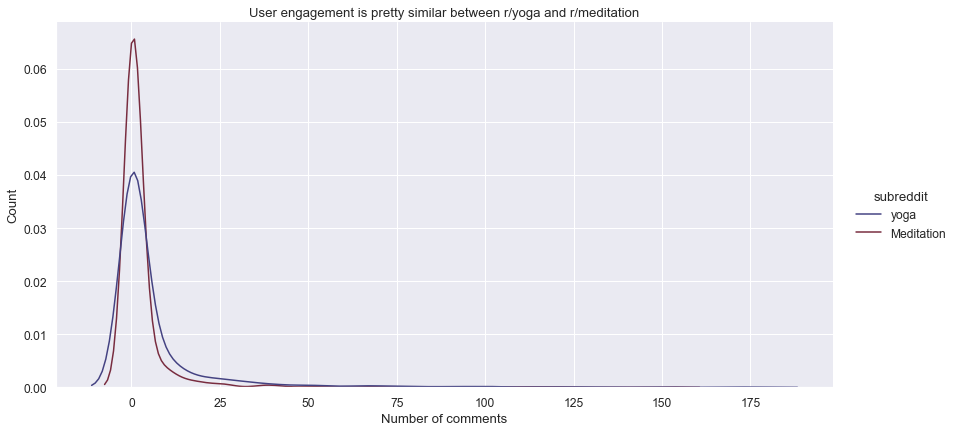

In [48]:
# Let's have a look at how many posts are missing text / removed?
g = sns.displot(data=merged, x='num_comments', kind='kde', hue='subreddit', palette="icefire", aspect=2, height=6)
plt.title("User engagement is pretty similar between r/yoga and r/meditation")
g.set_ylabels("Count")
g.set_xlabels("Number of comments")
plt.show()

**How many posts are missing text for both r/yoga and r/meditation?**

r/yoga subreddit posts appear to have more images / posts that have been removed as compared to meditation. This leaves us with a grand total of 948 text--only r/yoga posts compared to 1,262 text-only r/meditation posts.

In [10]:
# Let's look at the total number of posts containing text from both subreddits
merged.groupby(by="subreddit")['is_self'].sum()

subreddit
Meditation    1262
yoga           948
Name: is_self, dtype: int64

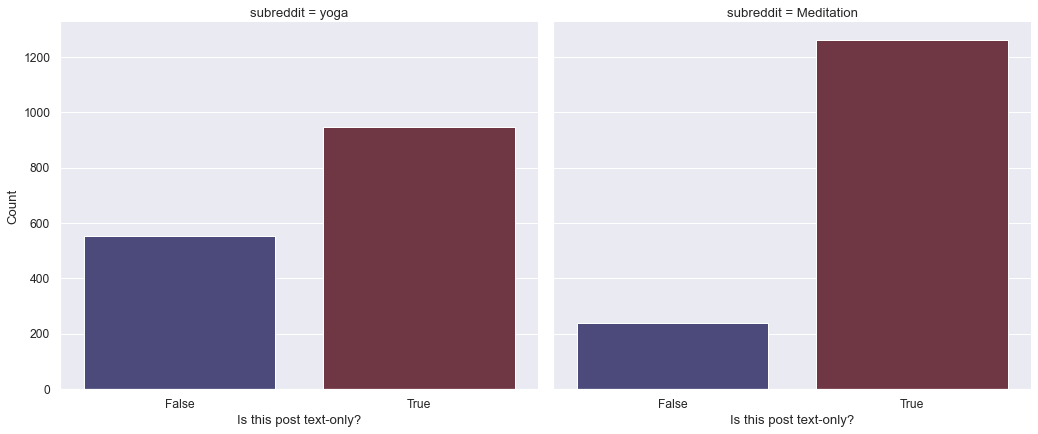

In [11]:
# Let's have a look at how many posts are missing text / removed?
g = sns.catplot(data=merged, x='is_self', kind='count', col='subreddit', palette="icefire", aspect=1.2, height=6)
g.set_ylabels("Count")
g.set_xlabels("Is this post text-only?")
plt.show()

**How many posts have been removed for both r/yoga and r/meditation?**

Moderators appear to play an outsized role in removing r/meditation posts. Several r/yoga posts were also removed via *automod*

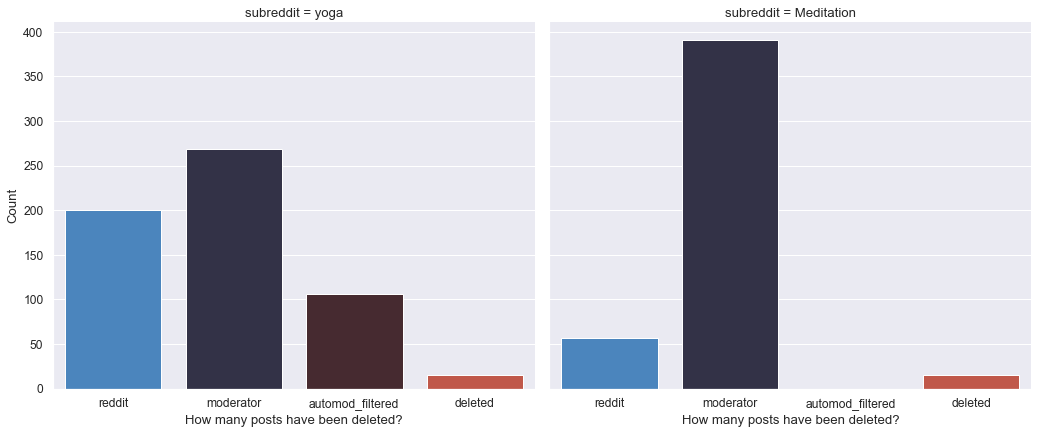

In [12]:
# Let's have a look at how many posts have been removed by admins
g = sns.catplot(data=merged, x='removed_by_category', kind='count', col='subreddit', palette="icefire", aspect=1.2, height=6)
g.set_ylabels("Count")
g.set_xlabels("How many posts have been deleted?")
plt.show()

**Are missing values handled appropriately?**

Based on what we see above, we'll need to filter out posts that contain no text, or have been removed by administrators (See below). This will result in a dataset without a 50-50 yoga/meditation split.

*Note*: Our baseline accuracy should still be 50%

In [13]:
# Let's filter for text-only posts / Filter for text-only posts
textonly = merged.loc[(merged['is_self']==True) & (merged['removed_by_category'].isna())]
textonly.head(2)

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,score,upvote_ratio
3,yoga,Extremely sore after my first hot vinyasa class,I am super out of shape so I am 90% sure that ...,True,0,1640903618,2021-12-31 06:33:38,NaN,meggriffinsglasses,/r/yoga/comments/rse7eh/extremely_sore_after_m...,1,1.0
4,yoga,Online new year's offerings?,"Hello yogis,\n\nAnybody aware of interesting y...",True,0,1640897639,2021-12-31 04:53:59,NaN,Friendly_Popo,/r/yoga/comments/rsbwvy/online_new_years_offer...,1,1.0


**Tidying up our title and selftext columns**

We have decided to utilise the *redditcleaner* package for this step. This python module removes characters stemming from (Reddit-specific) Markdown formatting and returns the cleaned text. Common punctuation, numbers, parentheses, quotation marks, emojis are deliberately not removed.

Source: https://github.com/LoLei/redditcleaner

In [14]:
# Clean titles
textonly['title'] = textonly['title'].map(redditcleaner.clean)

In [15]:
# Clean selftext
textonly['selftext'] = textonly['selftext'].map(str).map(redditcleaner.clean)

In [16]:
# Let's quickly computer lengths of title and selftext from both subreddits
length_distribution = pd.DataFrame()
length_distribution['subreddit'] = textonly['subreddit']
length_distribution['title_length'] = [len(sentence) for sentence in textonly['title']]
length_distribution['selftext_length'] = [len(sentence) for sentence in textonly['selftext']]

length_distribution.head(3)

,subreddit,title_length,selftext_length
3,yoga,47,1058
4,yoga,28,486
6,yoga,15,542


**Are there any significant differences in title / selftext (post) length from both subreddits?**

Overall title / self-text distributions of both subreddits are fairly similar (right-skewed). Title lengths are fairly similar but there is a significant difference in median self-text lengths (i.e. r/meditation posts being significantly longer).

*Note:* The total count of r/yoga and r/meditation posts have fallen again after filtering out missing data / posts that have been deleted by moderators

In [17]:
length_distribution.groupby(by='subreddit').describe().round(2).T

subreddit              Meditation     yoga
title_length    count      991.00   705.00
                mean        51.13    47.84
                std         37.57    41.56
                min          4.00     3.00
                25%         27.00    24.00
                50%         42.00    37.00
                75%         62.00    57.00
                max        299.00   288.00
selftext_length count      991.00   705.00
                mean       673.52   501.85
                std       1037.56   602.45
                min          1.00     3.00
                25%        202.00   193.00
                50%        431.00   369.00
                75%        778.50   616.00
                max      17624.00  8657.00

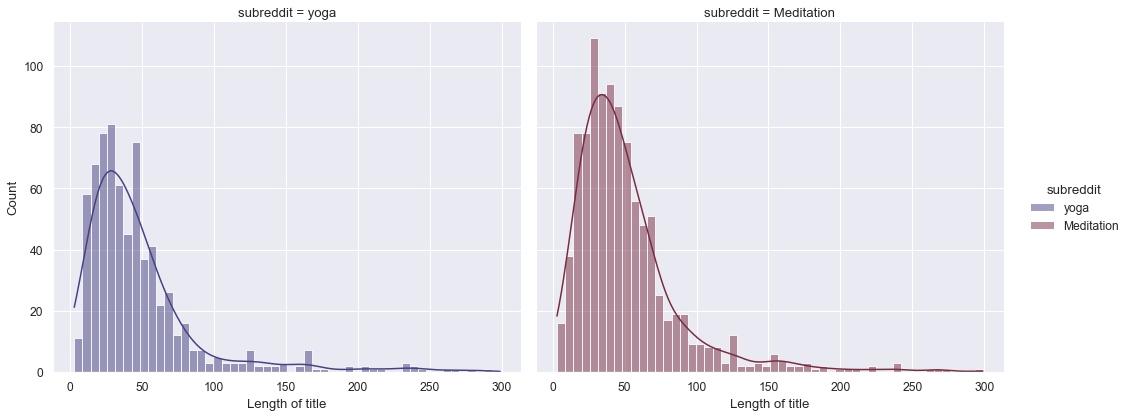

In [18]:
# Let's have a look at how many posts have been removed by admins
g = sns.displot(data=length_distribution, x='title_length', kind='hist', hue='subreddit',
                kde=True, col='subreddit', palette="icefire", aspect=1.2, height=6)

g.set_ylabels("Count")
g.set_xlabels("Length of title")
plt.show()

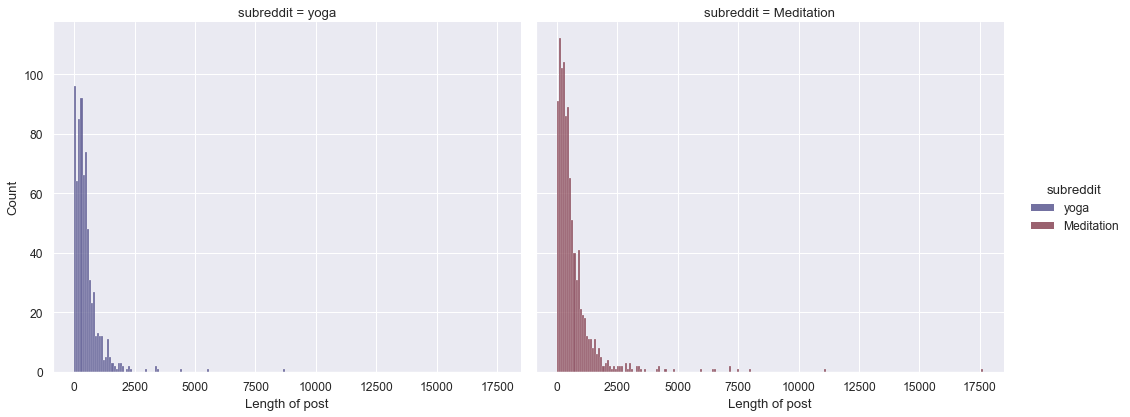

In [19]:
# Let's have a look at how many posts have been removed by admins
g = sns.displot(data=length_distribution, x='selftext_length', kind='hist', hue='subreddit',
                kde=False, col='subreddit', palette="icefire", aspect=1.2, height=6)

g.set_ylabels("Count")
g.set_xlabels("Length of post")
plt.show()

**Are there significant differences in sentiment between both subreddits?**

We will utilise the VADER package (Valence Aware Dictionary for Sentiment Reasoning), which is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.

VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

For example- Words like ‘love’, ‘enjoy’, ‘happy’, ‘like’ all convey a positive sentiment. Also VADER is intelligent enough to understand the basic context of these words, such as “did not love” as a negative statement. It also understands the emphasis of capitalization and punctuation, such as “ENJOY”

In [20]:
# Instantiate VADER sentiment analysis
sid = SentimentIntensityAnalyzer()

This package takes in a string and spits out a dictionary of scores in four categories: (1) negative, (2) neutral, (3) positive, (4) compound. We are only interested in the *compound* score (which is computed by normalising the scores mentioned earlier).

The compound score is between -1 (Most negative) and +1 (Most positive). 

In [21]:
# Obtaining our dictionary of polarity scores for titles
textonly['title_scores'] = textonly['title'].apply(lambda title: sid.polarity_scores(title))

# Obtaining compound scores for titles
textonly['title_sent'] = textonly['title_scores'].apply(lambda score_dict: score_dict['compound'])

In [22]:
textonly.head(2)

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,score,upvote_ratio,title_scores,title_sent
3,yoga,Extremely sore after my first hot vinyasa class,I am super out of shape so I am 90% sure that ...,True,0,1640903618,2021-12-31 06:33:38,NaN,meggriffinsglasses,/r/yoga/comments/rse7eh/extremely_sore_after_m...,1,1.0,"{'neg': 0.285, 'neu': 0.715, 'pos': 0.0, 'comp...",-0.4201
4,yoga,Online new year's offerings?,"Hello yogis, Anybody aware of interesting yoga...",True,0,1640897639,2021-12-31 04:53:59,NaN,Friendly_Popo,/r/yoga/comments/rsbwvy/online_new_years_offer...,1,1.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


**Sentiment analysis of our titles**

The overall compound scores for titles belonging to r/yoga and r/meditation are fairly similar. Nothing much we can glean from here.

In [23]:
mean_title_sent = textonly.groupby(by='subreddit')['title_sent'].describe().T
mean_title_sent

subreddit,Meditation,yoga
count,991.000000,705.000000
mean,0.052217,0.056794
std,0.327858,0.301443
min,-0.927400,-0.954300
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.250000,0.153100
max,0.961300,0.939500


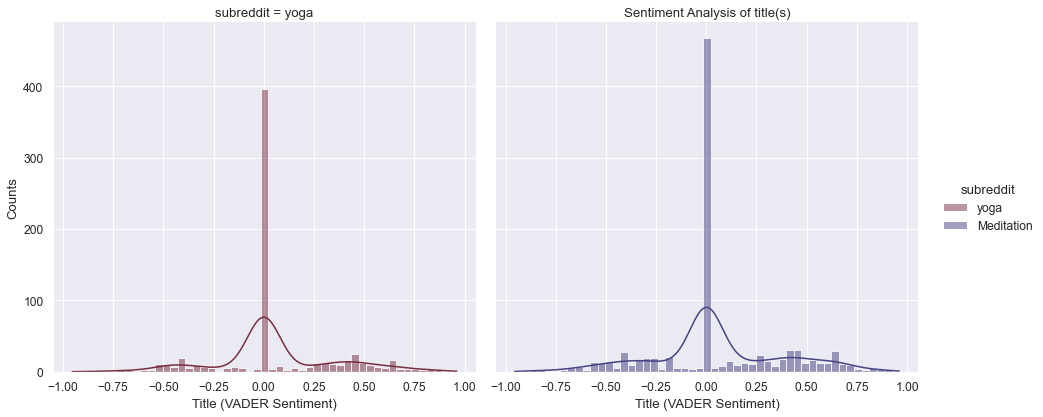

In [24]:
g = sns.displot(data=textonly, x='title_sent', col="subreddit", hue="subreddit", kind="hist", 
                kde = True, palette="icefire_r", aspect=1.1, height=6)

plt.title("Sentiment Analysis of title(s)")
g.set_ylabels("Counts")
g.set_xlabels("Title (VADER Sentiment)")
plt.show()

In [25]:
# Obtaining our dictionary of polarity scores for selftext
textonly['selftext_scores'] = textonly['selftext'].apply(lambda selftext: sid.polarity_scores(str(selftext)))

# Obtaining compound scores for selftext
textonly['selftext_sent'] = textonly['selftext_scores'].apply(lambda score_dict: score_dict['compound'])

**Sentiment analysis of our selftext**

Compared to titles, our overall compound scores for selftext have a positive tilt. Posts from r/meditation have a slightly higher median compound score relative to r/yoga. However, if we're looking at averages, r/meditation scores better here.

We posit that a few extremely negative-scoring posts may be dragging the overall mean scores of r/meditation lower.

In [26]:
mean_selftext_sent = textonly.groupby(by='subreddit')['selftext_sent'].describe().T
mean_selftext_sent

subreddit,Meditation,yoga
count,991.000000,705.000000
mean,0.378783,0.373862
std,0.610552,0.589271
min,-0.997200,-0.989700
25%,0.000000,0.000000
50%,0.622500,0.577500
75%,0.900800,0.887100
max,0.999700,0.997600


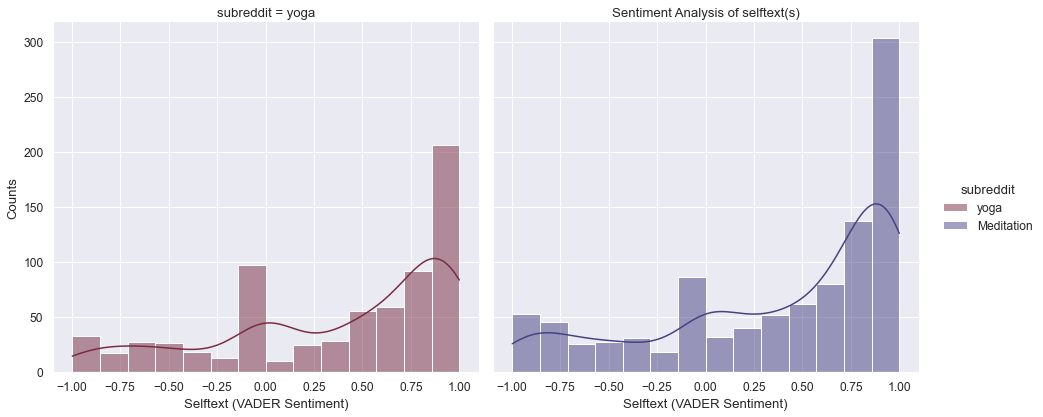

In [27]:
# Creating a histogram + kde plot to visualise the distribution of compound scores across r/yoga and r/meditation
g = sns.displot(data=textonly, x='selftext_sent', col="subreddit", hue="subreddit", kind='hist', kde=True, 
                palette='icefire_r', aspect=1.1, height=6)

plt.title("Sentiment Analysis of selftext(s)")
g.set_ylabels("Counts")
g.set_xlabels("Selftext (VADER Sentiment)")
plt.show()

In [28]:
# Taking a quick look at the outliers (negative) from r/meditation
textonly[(textonly['subreddit'] == 'Meditation') & (textonly['selftext_sent'] < -0.95)]['selftext'].head()

1521    I am no expert but I have been living in a dep...
1748    This might be a bit long  I was having a lot o...
1761    How do you guys get into the present during me...
1765    I cannot see the thoughts coming. I was diagno...
1779    Im 19yo and i never cared about brushing teeth...
Name: selftext, dtype: object

In [29]:
# Taking a quick look at the outliers (negative) from r/yoga
textonly[(textonly['subreddit'] == 'yoga') & (textonly['selftext_sent'] < -0.95)]['selftext'].head()

94     I had gone on an official trip in March 2021, ...
143    Hello beautiful humans. I have been practicing...
581    I was watching a yoga with Adrienne video on c...
709    I'm in real need of suggestions or help dealin...
892    Been doing yoga for about 4-5 years now. Start...
Name: selftext, dtype: object

We have decided to concatenate both titles and selftext columns to create a more representative dataframe that we will use to carry out NLP

In [30]:
# Combine titles and selftext
textonly['combined'] = textonly['title'] + " " + textonly['selftext']
textonly.head(2)

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,score,upvote_ratio,title_scores,title_sent,selftext_scores,selftext_sent,combined
3,yoga,Extremely sore after my first hot vinyasa class,I am super out of shape so I am 90% sure that ...,True,0,1640903618,2021-12-31 06:33:38,NaN,meggriffinsglasses,/r/yoga/comments/rse7eh/extremely_sore_after_m...,1,1.0,"{'neg': 0.285, 'neu': 0.715, 'pos': 0.0, 'comp...",-0.4201,"{'neg': 0.055, 'neu': 0.752, 'pos': 0.193, 'co...",0.9859,Extremely sore after my first hot vinyasa clas...
4,yoga,Online new year's offerings?,"Hello yogis, Anybody aware of interesting yoga...",True,0,1640897639,2021-12-31 04:53:59,NaN,Friendly_Popo,/r/yoga/comments/rsbwvy/online_new_years_offer...,1,1.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.048, 'neu': 0.789, 'pos': 0.164, 'co...",0.9029,"Online new year's offerings? Hello yogis, Anyb..."


## Pre-processing

These are the steps we will undertake next: 
* Converting words / characters to lowercase
* Lemmatising / stemming words
* Stop-word removal

In [31]:
# Selecting our columns of interest
messages = textonly[['subreddit', 'combined']]

In [32]:
# Tidying up our labels
messages['subreddit'] = messages['subreddit'].map({'yoga': 1, 'Meditation': 0})

In [33]:
# Converting sentences to lowercase
messages['combined'] = [word.lower() for word in messages['combined']]

In [34]:
# Preview dataframe
messages.head(2)

,subreddit,combined
3,1,extremely sore after my first hot vinyasa clas...
4,1,"online new year's offerings? hello yogis, anyb..."


### Lemmatization

**Why we're picking lemmatization over stemming?**

We're picking lemmatization over stemming as the latter is a somewhat cruder method for catalouging related words (It chops off letters from the end until the stem is reached). We are also not prioritising speed in this instance.

Lemmatization looks beyond word reduction and considers a language's full vocabulary to apply a morphological analysis to words/ It is hence more informative than simple stemming and that is one of the main reasons why we've decided to employ this text normalization technique in our project.

**Tweaking the part-of-speech tag**

The next question we need to be asking ourselves is whether we need to tweak the 'part-of-speech' tag as the second argument to ```lemmatize()```

In [35]:
# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [36]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [37]:
# Testing our function
word='did'
print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

do


In [38]:
%%time

# Let's now lemmitise our selftext
messages['selftext_lem'] = [' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
                                      for word in text.split(' ')]) for text in messages['combined']]

Wall time: 1min 58s


In [39]:
# Preview dataframe (Comparison between lemmatized text and original)
messages.head(2)

,subreddit,combined,selftext_lem
3,1,extremely sore after my first hot vinyasa clas...,extremely sore after my first hot vinyasa clas...
4,1,"online new year's offerings? hello yogis, anyb...","online new year's offerings? hello yogis, anyb..."


### Removal of stop-words

I've decided to use the gensim package primarily because there is an easy wrapper function to remove stop-words.

*Note: Pros and cons of different packages are listed below:*

https://medium.com/activewizards-machine-learning-company/comparison-of-top-6-python-nlp-libraries-c4ce160237eb

In [40]:
# Let's have a quick look at the stopwords from the gensim package
all_stopwords = gensim.parsing.preprocessing.STOPWORDS
print(all_stopwords)

frozenset({'they', 'some', 'everyone', 'various', 'one', 'further', 'will', 'whereas', 'nor', 'yourself', 'back', 'by', 'seeming', 'them', 'out', 'get', 'de', 'thereafter', 'hereby', 'at', 'more', 'take', 'five', 'where', 'make', 'mostly', 'although', 'down', 'anything', 'no', 'very', 'have', 'were', 'hers', 'my', 'himself', 'already', 'beforehand', 'hereupon', 'un', 'side', 'other', 'everything', 'and', 'without', 'those', 'latterly', 'due', 'an', 'can', 'which', 'towards', 'also', 'each', 'etc', 'before', 'formerly', 'last', 'next', 'amongst', 'name', 'what', 'don', 'thru', 'whence', 'sometimes', 'through', 'i', 'besides', 'find', 'did', 'alone', 'top', 'thick', 'three', 'thereby', 'about', 'would', 'must', 'wherein', 'until', 'twenty', 'whom', 'might', 'amoungst', 'wherever', 'any', 'the', 'anyway', 'only', 'bill', 'itself', 'sometime', 'system', 'since', 'hasnt', 'co', 'thus', 'over', 'because', 'may', 'least', 'even', 'had', 'during', 'whereupon', 'nowhere', 'around', 'bottom', 'd

In [41]:
# Let's remove stopwords (via the gensim package) from the selftext
messages['selftext_gensim'] = [remove_stopwords(text) for text in messages['selftext_lem']]

In [42]:
# Let's have a look at the stopwords from the ntlk package now
all_stopwords_alt = set(stopwords.words('english'))
print(all_stopwords_alt)

{'about', 'they', 'some', 'up', 'or', 'being', 'so', 'too', 'yours', 'myself', 'further', "couldn't", "you're", "isn't", 'until', 'will', 'won', 'whom', 'between', 'above', "shouldn't", 'having', 'nor', 'any', 'yourself', 'here', 'the', 'be', 'hadn', "wasn't", "wouldn't", 'itself', 'his', 'only', 'by', 'is', 'its', 'them', 'out', "won't", 'off', "mustn't", 'over', 'y', 'because', "she's", 'at', 'theirs', 'this', 'more', 'shan', "weren't", 'had', 'during', 'couldn', 'where', 'these', 'mightn', 'ain', 'now', 'she', 'their', 'ourselves', 'down', 'no', 'doesn', 'me', 'mustn', 'very', 'isn', 'once', 'if', 'have', 'ours', 'been', 'doing', 'were', 's', 'was', 'a', 'm', 'hers', "shan't", 'needn', 'my', 'himself', "it's", 'both', 'again', "aren't", 'shouldn', 'does', 'o', "needn't", "should've", 'how', 'in', 'our', 'such', 'we', 'other', "you've", 'that', 'you', 'and', 'of', 'those', 've', 'against', 't', 'from', 'your', 'wouldn', 'into', 'not', 'an', 'than', 'can', 'same', 'weren', 'haven', 'w

A quick comparison between *gensim* and *ntlk* stopwords highlight's *gensim's* comprehensiveness

In [43]:
# # Let's remove stopwords again (Using ntlk's package this time)
# messages['selftext_ntlk'] = [' '.join([word for word in text.split(' ') 
#                                              if not word in stop_words]) 
#                                    for text in messages['selftext_lem']]

In [44]:
# Let's preview our dataset
messages.head(10)

,subreddit,combined,selftext_lem,selftext_gensim
3,1,extremely sore after my first hot vinyasa clas...,extremely sore after my first hot vinyasa clas...,extremely sore hot vinyasa class super shape 9...
4,1,"online new year's offerings? hello yogis, anyb...","online new year's offerings? hello yogis, anyb...","online new year's offerings? hello yogis, anyb..."
6,1,yoga with covid hi all. i was diagnosed with c...,yoga with covid hi all. i be diagnose with cov...,yoga covid hi all. diagnose covid week it's re...
10,1,my heart is so full. i just came from a 75 min...,my heart be so full. i just come from a 75 min...,heart full. come 75 minute class sob end. teac...
11,1,"down dog app - star to side lunge okay, down d...","down dog app - star to side lunge okay, down d...","dog app - star lunge okay, dog app finally bea..."
13,1,sacred cacao ceremony i am usually a straight ...,sacred cacao ceremony i be usually a straight ...,sacred cacao ceremony usually straight hot yog...
15,1,questions on getting started i am interested i...,question on get start i be interested in get s...,question start interested start yoga. look str...
17,1,men's yoga suggestions? hello everyone i have ...,men's yoga suggestions? hello everyone i have ...,men's yoga suggestions? hello convince husband...
18,1,results of yoga on your body/fitness level i h...,result of yoga on your body/fitness level i ha...,result yoga body/fitness level recently yoga a...
19,1,pelvic tilt and yoga practice. just want to sh...,pelvic tilt and yoga practice. just want to sh...,pelvic tilt yoga practice. want share obvious ...


In [45]:
from wordcloud import WordCloud, STOPWORDS
list_of_words = [" ".join(sentence for sentence in messages['selftext_gensim'])]

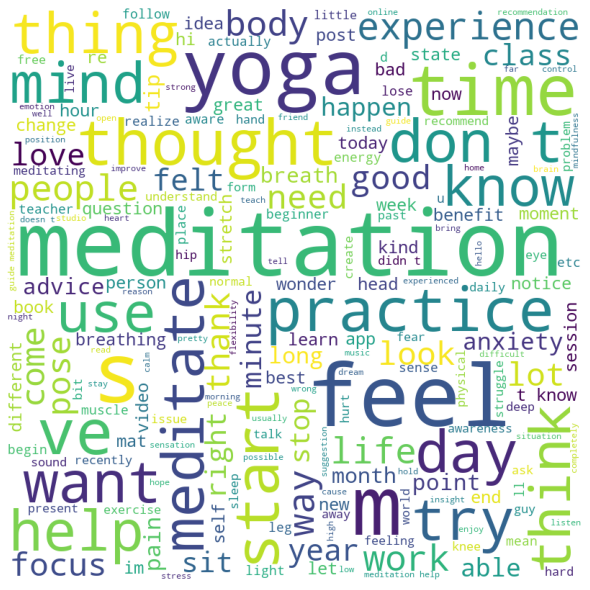

In [46]:
# Let's create a wordcloud to see the common themes in the selftext
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(str(list_of_words))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Based on the word cloud generated above, there are certain words that need to be manually removed later during the pipeline process (i.e. yoga, meditate, meditation). 

In [47]:
# Write to csvr
messages.to_csv('../data/cleaned_messages.csv')

Please head over to our next workbook titled: ```project_3_modelling```